In [8]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 63.8 ms


In [3]:
import sys
sys.path.append('../src')
from main import load_data
from preprocessing import clean_text, remove_stop_words, negation_handling, lemmatizing, emoji_tagging
from features_extractor import Extractor, extract_tf, extract_tf_idf, extract_sentiment

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from util import curry
from pprint import pprint

import matplotlib.pyplot as plt
import copy

In [4]:
Xtr_text, Ytr, Xte_text, Yte = load_data('../aclImdb/train/', '../aclImdb/test/')

Load Data...
Done loading data!



In [5]:
ngram_range = (1,1)
min_df=2
max_df=0.5
n_features=2

In [6]:
Xtr_text.shape

(25000,)

In [7]:
Xtr, Xte = Extractor(Xtr_text, Xte_text)\
        .bind(curry(emoji_tagging))\
        .bind(curry(remove_stop_words))\
        .bind(curry(lemmatizing))\
        .bind(curry(negation_handling))\
        .bind(curry(clean_text))\
        .bind(extract_tf(ngram_range=ngram_range, min_df=min_df,max_df=max_df))\
        .bind(extract_tf_idf)\
        .get_features()

In [13]:
def lsa(Xtr, Xte, n_components):
    svd = TruncatedSVD(n_components)
    lsa = make_pipeline(svd, Normalizer(copy=False))

    lsa.fit(Xtr)
    Xtr_lsa = lsa.transform(Xtr)
    Xte_lsa = lsa.transform(Xte)

    return Xtr_lsa, Xte_lsa

def svd(Xtr, Xte, n_components):
    svd = TruncatedSVD(n_components)
    svd.fit(Xtr)
    Xtr_lsa = svd.transform(Xtr)
    Xte_lsa = svd.transform(Xte)

    return Xtr_lsa, Xte_lsa
    
def k_best(Xtr, Ytr, Xte, Yte, k_best):
    Select = SelectKBest(chi2, k=k_best).fit(Xtr, Ytr)
    XtrS = Select.transform(Xtr)
    XteS = Select.transform(Xte)
    
    return XtrS, XteS

def run_classifier(Xtr, Ytr, Xte, Yte):
    classifier = LogisticRegression(solver='lbfgs')
    classifier.fit(Xtr, Ytr)
    Yte_hat = classifier.predict(Xte)

    f1 = f1_score(Yte, Yte_hat)
    p = precision_score(Yte, Yte_hat)
    r = recall_score(Yte, Yte_hat)
    return [f1, p, r]

In [14]:
Xtr_lsa, Xte_lsa = lsa(Xtr, Xte, 2)

In [15]:
Xtr_svd, Xte_svd = svd(Xtr, Xte, 2)

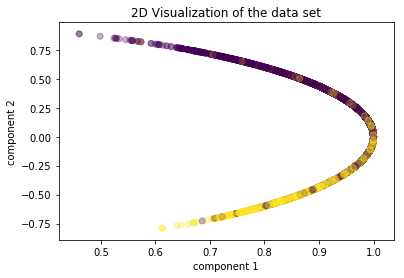

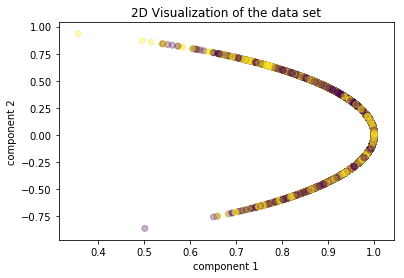

In [18]:
plt.scatter(Xtr_lsa[:,0], Xtr_lsa[:,1], c=Ytr, alpha=0.3)
plt.title("2D Visualization of the data set")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.savefig('2d-data-visualization-train-lsa.png', bbox_inches='tight')
plt.show()

plt.scatter(Xte_lsa[:,0], Xte_lsa[:,1], c=Ytr, alpha=0.3)
plt.title("2D Visualization of the data set")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.savefig('2d-data-visualization-test-lsa.png', bbox_inches='tight')
plt.show()

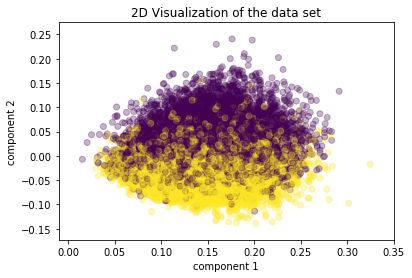

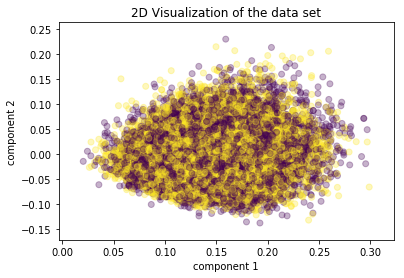

In [17]:
plt.scatter(Xtr_svd[:,0], Xtr_svd[:,1], c=Ytr, alpha=0.3)
plt.title("2D Visualization of the data set")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.savefig('2d-data-visualization-train-svd.png', bbox_inches='tight')
plt.show()

plt.scatter(Xte_svd[:,0], Xte_svd[:,1], c=Ytr, alpha=0.3)
plt.title("2D Visualization of the data set")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.savefig('2d-data-visualization-test-svd.png', bbox_inches='tight')
plt.show()